# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Первым делом импортируем необходимые для работы средства.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

import time 

from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder, StandardScaler

Прочитаем файл и сохраним его в переменной df.

In [2]:
df = pd.read_csv('/datasets/autos.csv')

Получим общую информацию о датафрейме.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Исходя из документации к данным мы знаем, что **DateCrawled** — дата скачивания анкеты из базы,
**VehicleType** — тип автомобильного кузова,
**RegistrationYear** — год регистрации автомобиля,
**Gearbox** — тип коробки передач,
**Power** — мощность (л. с.),
**Model** — модель автомобиля,
**Kilometer** — пробег (км),
**RegistrationMonth** — месяц регистрации автомобиля,
**FuelType** — тип топлива,
**Brand** — марка автомобиля,
**NotRepaired** — была машина в ремонте или нет,
**DateCreated** — дата создания анкеты,
**NumberOfPictures** — количество фотографий автомобиля,
**PostalCode** — почтовый индекс владельца анкеты (пользователя),
**LastSeen** — дата последней активности пользователя,
**Price** — цена (евро).

Также можно заметить, что количество данных в столбцах разнится.

Выведем первые пять строк таблиц на экран

In [4]:
display(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Проверим данные на наличие дубликатов.

In [5]:
df.duplicated().sum()

4

Удалим дубликаты.

In [6]:
df = df.drop_duplicates()

Проверим количество пропусков в данных

In [7]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Много пропусков в столбце Model, восстановить модель автомобиля невозможно, поэтому заполним пропуски other.

In [8]:
df['Model'] = df['Model'].fillna('other')

Пропуски в столбце NotRepaired заменим категорией yes, предположим, что автомобиль был в ремонте.

In [9]:
df['NotRepaired'] = df['NotRepaired'].fillna('yes')

Предположим, что в пропущенных значениях в столбце с типом коробки передач механическая коробка, так как она наиболее распространена.

In [10]:
df['Gearbox'] = df['Gearbox'].fillna('manual')

Тип кузова и тип топлива имеют большое значение, в этих столбцах пропуски необходимо заполнить.

In [11]:
df["VehicleType"] = df["VehicleType"].fillna(df["VehicleType"].mode().values[0])

In [12]:
df["FuelType"] = df["FuelType"].fillna(df["FuelType"].mode().values[0])

Все пропуски заполнены, но убедимся в этом.

In [13]:
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Посмотрим уникальные значения в столбце Price.

In [14]:
df['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

In [15]:
df['Price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

Мы видим, что в столбце встречаются нулевые значения. Удалим их, так как автомобиль не может отдаваться бесплатно.

In [16]:
df = df.query('Price != 0 and Price > 49')

Посмотрим уникальные значения столбца Power.

In [17]:
df['Power'].value_counts()

0        35533
75       23239
60       15428
150      14113
101      12931
         ...  
923          1
10910        1
9013         1
4400         1
6006         1
Name: Power, Length: 698, dtype: int64

Мы видим выбросы - есть как нулевые значения, так и неправдоподобно большие. Рассмотрим их на графике.

Text(0, 0.5, 'Количество')

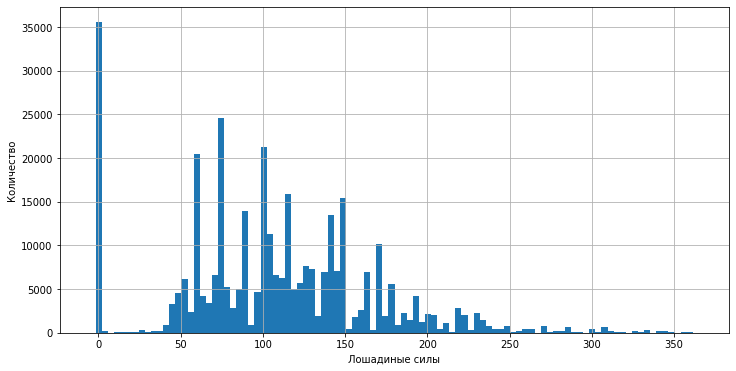

In [18]:
Q1 = df['Power'].quantile(0.25)
Q3 = df['Power'].quantile(0.75)
IQR = Q3 - Q1
fig, ax = plt.subplots()
df['Power'].plot(kind = 'hist', bins = 100, grid = True, range = (Q1 - IQR, Q3 + 3*IQR), figsize = (12, 6))
ax.set_xlabel('Лошадиные силы')
ax.set_ylabel('Количество')

Удалим нулевые значения, а также те, которые больше 1600, так как это максимально возможная мощность.

In [19]:
df = df.query('Power != 0 and Power <= 1600')

Изучим год регистрации автомобиля.

In [20]:
df['RegistrationYear'].value_counts()

1999    19527
2005    18899
2000    18729
2006    18570
2003    17924
        ...  
1947        1
1948        1
1949        1
9999        1
2800        1
Name: RegistrationYear, Length: 109, dtype: int64

Год не может быть 1000 или 9000, так как автомобили появились только в ХХ веке, а год позже 2022 ещё не наступил. В сороковых годах прошлого века автомобили уже выпускались, но их состояние может быть плохим. Удалим данные с годом меньше 1960, так как машина этого года выпуска ещё может быть "на ходу".

In [21]:
df = df.query('RegistrationYear >= 1960 and RegistrationYear < 2016')

Посмотрим на распределение по месяцам.

In [22]:
df['RegistrationMonth'].value_counts()

3     29932
6     26998
4     25271
5     25126
7     23382
10    22529
12    20879
11    20680
9     20597
1     19868
8     19333
2     18546
0     16348
Name: RegistrationMonth, dtype: int64

Снова видим нулевые значения, их нужно удалить

In [23]:
df = df.query('RegistrationMonth != 0')

Посмотрим значения в столбце Kilometer.

In [24]:
df['Kilometer'].value_counts()

150000    178444
125000     30019
100000     12171
90000       9874
80000       8670
70000       7555
60000       6636
50000       5509
40000       4416
30000       3782
20000       3102
5000        2069
10000        894
Name: Kilometer, dtype: int64

Показатели километража нормальные, похожи на реальные значения.

Посмотрим какой процент данных остался после предобработки данных.

In [25]:
df.shape[0]/354369

0.7707813042337225

Мы удалили 23% данных, это немало, но это были аномальные значения. Теперь данные стали чище и с ними можно работать.

**Вывод**

В ходе подготовки данных мы нашли и удалили дубликаты, заполнили пропуски, а также удалили нулевые и слишком большие значения в данных. Теперь датафрейм стал чище, можно переходить к обучению моделей.

## Обучение моделей

Сначала удалим столбцы, которые не потребуются для обучения моделей.

In [26]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

Проведём кодирование категориальных данных с помощью Label Encoder.

In [27]:
cats_cols = list(df.select_dtypes(include='object').columns)
label_encode = LabelEncoder()
for column in cats_cols:
    label_encode.fit(df[column].astype('str'))
    df[column] = label_encode.transform(df[column].astype('str'))

Теперь выделим признаки для обучения и целевой признак.

In [28]:
features = df.drop('Price', axis=1)
target = df['Price']

Теперь разделим выборку на обучающую и валидационную.

In [29]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

Теперь валидационную выборку разделим на валидационную и тестовую.

In [30]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

Теперь стандартизируем данные.

In [31]:
def scale_to_standard(train, test, valid):
    scaler = StandardScaler()
    quanti_columns = ['RegistrationYear', 'Power', 'Kilometer']
    scaler.fit(train[quanti_columns])
    train[quanti_columns] = scaler.transform(train[quanti_columns])
    valid[quanti_columns]=scaler.transform(valid[quanti_columns])
    test[quanti_columns] = scaler.transform(test[quanti_columns])

In [32]:
scale_to_standard(features_train, features_test, features_valid)

/tmp/ipykernel_31/1018154665.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[quanti_columns] = scaler.transform(train[quanti_columns])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


Обучим модель с помощью LGBMRegressor.

In [33]:
def lgb_regr(features, target):
    model = LGBMRegressor()
    params = {
        'boosting_type' : ['gbdt'],
        'n_estimators' : [50, 100],
        'max_depth' : [5, 7, 10],
        'verbose' : [0],
        'random_state' : [12345],
        'force_col_wise': [True],
        'num_leaves' : [127]}
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target, categorical_feature=cats_cols)
    print('Best hyperparams: ', grid_cv.best_params_)
    print('RMSE score on train sample: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [34]:
%%time
lgb_params = lgb_regr(features_train, target_train)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best hyperparams:  {'boosting_type': 'gbdt', 'force_col_wise': True, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 127, 'random_state': 12345, 'verbose': 0}
RMSE score on train sample: 1558.13
CPU times: user 41min 57s, sys: 5.4 s, total: 42min 3s
Wall time: 42min 7s


In [35]:
%%time
model_lgb = LGBMRegressor(**lgb_params)
model_lgb.fit(features_train, target_train, eval_set=(features_test, target_test), verbose=10, eval_metric='rmse')

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's rmse: 2474.85	valid_0's l2: 6.12488e+06
[20]	valid_0's rmse: 1916.13	valid_0's l2: 3.67156e+06
[30]	valid_0's rmse: 1751.87	valid_0's l2: 3.06903e+06
[40]	valid_0's rmse: 1683.76	valid_0's l2: 2.83503e+06
[50]	valid_0's rmse: 1650.44	valid_0's l2: 2.72395e+06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's rmse: 1630.31	valid_0's l2: 2.65791e+06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's rmse: 1619.54	valid_0's l2: 2.6229e+06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's rmse: 1606.13	valid_0's l2: 2.57965e+06
[90]	valid_0's rmse: 1595.49	valid_0's l2: 2.5456e+06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LGBMRegressor(force_col_wise=True, max_depth=10, num_leaves=127,
              random_state=12345, verbose=0)

Оценим предсказания и RMSE.

In [36]:
%%time
predict_lgb = model_lgb.predict(features_valid)
print('Valid RMSE = {:.2f}'.format(mse(target_valid, predict_lgb)**0.5))

Valid RMSE = 1594.19
CPU times: user 441 ms, sys: 3.96 ms, total: 445 ms
Wall time: 322 ms


На обучающей выборке наилучшее значение RMSE равно 1633.35. На валидационной выборке модель показывает значение RMSE 1670.31.

Обучим модель с помощью CatBoostRegressor.

In [37]:
def catboost_regr(features, target):
    model = CatBoostRegressor()
    params = {
            'n_estimators' : [50, 100],
            'verbose' : [0],
            'random_state' : [12345],
            'max_depth' : [5, 7, 10]
    }
    grid_cv = GridSearchCV(estimator=model, 
    param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target, cat_features=cats_cols, verbose=10)
    print('Best hyperparams: ', grid_cv.best_params_)
    print('RMSE score on train sample: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [38]:
%%time
catb_params = catboost_regr(features_train, target_train)

Learning rate set to 0.5
0:	learn: 3269.3770036	total: 95.6ms	remaining: 4.68s
10:	learn: 1906.5717062	total: 470ms	remaining: 1.67s
20:	learn: 1812.4720924	total: 817ms	remaining: 1.13s
30:	learn: 1767.1692871	total: 1.16s	remaining: 713ms
40:	learn: 1735.7500114	total: 1.51s	remaining: 331ms
49:	learn: 1716.9207181	total: 1.83s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3275.9516108	total: 41.9ms	remaining: 2.05s
10:	learn: 1922.7300710	total: 420ms	remaining: 1.49s
20:	learn: 1826.1605731	total: 769ms	remaining: 1.06s
30:	learn: 1772.6121639	total: 1.11s	remaining: 683ms
40:	learn: 1742.2513450	total: 1.48s	remaining: 325ms
49:	learn: 1721.6042982	total: 1.8s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3312.7183622	total: 44.5ms	remaining: 2.18s
10:	learn: 1924.6924926	total: 432ms	remaining: 1.53s
20:	learn: 1831.9384941	total: 809ms	remaining: 1.12s
30:	learn: 1775.9906779	total: 1.18s	remaining: 720ms
40:	learn: 1740.0192645	total: 1.54s	remaining: 338ms
49:	learn: 1

In [39]:
%%time
catb_model = CatBoostRegressor(**catb_params)
catb_model.fit(features_train, target_train, verbose=10)

Learning rate set to 0.5
0:	learn: 3094.4145066	total: 49.9ms	remaining: 4.94s
10:	learn: 1759.8304519	total: 577ms	remaining: 4.67s
20:	learn: 1664.1635652	total: 1.09s	remaining: 4.1s
30:	learn: 1614.5702965	total: 1.59s	remaining: 3.54s
40:	learn: 1573.9415889	total: 2.08s	remaining: 3s
50:	learn: 1535.6122885	total: 2.58s	remaining: 2.48s
60:	learn: 1507.0941906	total: 3.09s	remaining: 1.98s
70:	learn: 1484.8780227	total: 3.6s	remaining: 1.47s
80:	learn: 1462.8662414	total: 4.1s	remaining: 963ms
90:	learn: 1444.9975451	total: 4.62s	remaining: 457ms
99:	learn: 1429.8801480	total: 5.07s	remaining: 0us
CPU times: user 5.22 s, sys: 12 ms, total: 5.23 s
Wall time: 5.67 s


Оценим предсказания и RMSE.

In [40]:
%%time
catb_pred = catb_model.predict(features_valid)
print('Valid RMSE : {:.2f} '.format(mse(target_valid, catb_pred)**0.5))

Valid RMSE : 1590.38 
CPU times: user 16.5 ms, sys: 4.05 ms, total: 20.5 ms
Wall time: 19 ms


На обучающей выборке наилучшее значение RMSE равно 1490.92. На валидационной выборке модель показывает значение RMSE 1669.07.

Обучим модель с помощью XGBRegressor.

In [41]:
def xgb_regr(features, target):
    model = XGBRegressor()
    params = {
        'max_depth': [3, 5, 7], 
         'eta': [0.5], 
         'min_child_weight':[4],
         'sampling_method':['gradient_based'], 
         'verbosity':[1],  
         'seed':[12345]}
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=2, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target, eval_metric='rmse', verbose = 10, eval_set = [(features_test, target_test)])
    print('Best hyperparams: ', grid_cv.best_params_)
    print('Best RMSE score: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [42]:
%%time
xgb_params = xgb_regr(features_train, target_train)

[0]	validation_0-rmse:4209.24561
[10]	validation_0-rmse:2078.67212
[20]	validation_0-rmse:1939.48596
[30]	validation_0-rmse:1879.07727
[40]	validation_0-rmse:1833.41113
[50]	validation_0-rmse:1810.09949
[60]	validation_0-rmse:1797.10486
[70]	validation_0-rmse:1784.45203
[80]	validation_0-rmse:1772.36585
[90]	validation_0-rmse:1756.97412
[99]	validation_0-rmse:1750.24634
[0]	validation_0-rmse:4212.95410
[10]	validation_0-rmse:2063.28320
[20]	validation_0-rmse:1951.88159
[30]	validation_0-rmse:1884.53162
[40]	validation_0-rmse:1846.44055
[50]	validation_0-rmse:1820.79065
[60]	validation_0-rmse:1801.35974
[70]	validation_0-rmse:1784.48486
[80]	validation_0-rmse:1767.30273
[90]	validation_0-rmse:1755.90222
[99]	validation_0-rmse:1748.29993
[0]	validation_0-rmse:4013.92725
[10]	validation_0-rmse:1851.78516
[20]	validation_0-rmse:1787.40186
[30]	validation_0-rmse:1746.57202
[40]	validation_0-rmse:1723.65918
[50]	validation_0-rmse:1708.41919
[60]	validation_0-rmse:1695.11646
[70]	validation_0

In [43]:
%%time
model_xgb = XGBRegressor(**xgb_params)
model_xgb.fit(features_train, target_train, eval_metric='rmse', verbose = 10, eval_set = [(features_test, target_test)])

[0]	validation_0-rmse:3919.12744
[10]	validation_0-rmse:1742.86047
[20]	validation_0-rmse:1668.94250
[30]	validation_0-rmse:1634.23926
[40]	validation_0-rmse:1619.26062
[50]	validation_0-rmse:1604.59753
[60]	validation_0-rmse:1597.12744
[70]	validation_0-rmse:1595.46423
[80]	validation_0-rmse:1590.57068
[90]	validation_0-rmse:1581.63965
[99]	validation_0-rmse:1577.20960
CPU times: user 1min 6s, sys: 54.9 ms, total: 1min 6s
Wall time: 1min 6s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.5, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=7, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=12345,
             reg_alpha=0, reg_lambda=1, sampling_method='gradient_based',
             scale_pos_weight=1, seed=12345, subsample=1, tree_method='exact',
             validate_parameters=1, ...)

Оценим предсказания и RMSE.

In [44]:
%%time
xgb_pred = model_xgb.predict(features_valid)
print('Valid RMSE : {:.2f}'.format(mse(target_valid, xgb_pred)**0.5))

Valid RMSE : 1599.96
CPU times: user 134 ms, sys: 0 ns, total: 134 ms
Wall time: 85.7 ms


На обучающей выборке наилучшее значение RMSE равно 1631.65. На валидационной выборке модель показывает значение RMSE 1664.78.

Применим линейную регрессию. Для этого сначала закодируем выборку с помощью OHE.

In [47]:
df_ohe = pd.get_dummies(df, drop_first=True)
features_ohe = df_ohe.drop('Price', axis=1)
target_ohe = df_ohe['Price']

Разделим выборку на обучающую и валидационную.

In [48]:
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.25, random_state=12345)

Теперь валидационную выборку разделим на валидационную и тестовую.

In [49]:
features_valid_ohe, features_test_ohe_ohe, target_valid_ohe, target_test_ohe = train_test_split(
    features_valid_ohe, target_valid_ohe, test_size=0.5, random_state=12345)

Перейдём к обучению модели.

In [50]:
%%time
model = LinearRegression()
model.fit(features_train_ohe,target_train_ohe)

CPU times: user 55.4 ms, sys: 12.1 ms, total: 67.5 ms
Wall time: 41.3 ms


LinearRegression()

Оценим предсказания и RMSE.

In [51]:
%%time
lnr_pred = model.predict(features_valid_ohe)
print('Valid RMSE : {:.2f}'.format(mse(target_valid_ohe, lnr_pred)**0.5))

Valid RMSE : 3045.06
CPU times: user 256 µs, sys: 28.3 ms, total: 28.6 ms
Wall time: 5.75 ms


Мы видим, что модель обучается быстро, но RMSE высокое - 3045.06.

**Вывод**

Итак, в ходе обучения моделей мы обучили и сравнили четыре модели: LGBMRegressor, CatBoostRegressor, XGBRegressor, линейную регрессию. Выделили наилучшие значения в каждой модели.

## Анализ моделей

Проведём анализ обученных моделей - сравним значения RMSE и время, затраченное на обучение.

In [52]:
results = {
    'Model' : ['LGBMRegressor', 'CatBoostRegressor', 'XGBRegressor', 'LinearRegression'],
    'Train RMSE' :pd.Series([1588.89, 1429.88, 1577.2, 3045.06]),
    'Время обучения, sec': pd.Series([10.5, 5.41, 61, 0.041]),
    'Valid RMSE' :pd.Series([1594.19, 1590.38, 1599.96, 3045.06]),
    'Время предсказания, sec': pd.Series([0.401, 0.017, 0.149, 0.005])
    }
display(pd.DataFrame(results))


,Model,Train RMSE,"Время обучения, sec",Valid RMSE,"Время предсказания, sec"
0,LGBMRegressor,1588.89,10.500,1594.19,0.401
1,CatBoostRegressor,1429.88,5.410,1590.38,0.017
2,XGBRegressor,1577.20,61.000,1599.96,0.149
3,LinearRegression,3045.06,0.041,3045.06,0.005


В таблице мы видим, что на обучающей выборке по значению RMSE и по времени наилучший результат показала CatBoostRegressor. На валидационной выборке эта модель тоже справилась значительно быстрее других, значение RMSE минимальное. Далее идёт XGBRegressor, она показывает неплохие значения, но обучается медленнее. LGBMRegressor обучается ещё немного медленнее других моделей, её значения близки к показателям LGBMRegressor и CatBoostRegressor. Самой медленной оказалась LinearRegression, также она показывает самое высокое значение RMSE, которое не соответствует условию исследования.

Лучше всего тсебя показала модель CatBoostRegressor, так как она довольно быстро обучается и у неё хорошее значение RMSE.

Протестируем модель на тестовой выборке.

In [53]:
%%time
model = CatBoostRegressor(max_depth = 10, n_estimators = 100, random_state = 12345, verbose = 0)
catb_model.fit(features_train, target_train)
catb_pred = catb_model.predict(features_test)
print('Test RMSE : {:.2f} '.format(mse(target_test, catb_pred)**0.5))

Test RMSE : 1590.73 
CPU times: user 5.25 s, sys: 28.1 ms, total: 5.28 s
Wall time: 5.72 s


Модель обучается быстро за 5.72 секунды. Значение RMSE 1590.73, это соответствует условию проекта. Мы выбрали хорошую модель, которая тратит мало времени на обучение, ошибок допустимое количество.